In [1]:
# **Imports**
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, TimeDistributed, RepeatVector
from keras.layers import SimpleRNN, LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading and Preparing the data

## Loading the Data 

In [4]:
# uploading the files to GC in order to use them. If you use the file in GCP more often, use a DIFFERENT method like connecting to your Drive, like shown below.
from google.colab import files
uploaded1 = files.upload()

Saving df_deutschland.csv to df_deutschland.csv


In [5]:
uploaded2 = files.upload()

Saving wind_hourly_clean.csv to wind_hourly_clean.csv


In [4]:
local_path_target = '/mnt/g/Meine Ablage/raw_data/Target/Hourly/energy_generation_data/df_deutschland.csv'

local_path_feature = "/mnt/g/Meine Ablage/raw_data/Features/DATAFRAMES/wind_hourly_clean.csv"

#data_target = pd.read_csv('df_deutschland.csv')
#data_feature = pd.read_csv("wind_hourly_clean.csv")

data_target = pd.read_csv('/content/drive/MyDrive/raw_data/Target/Hourly/energy_generation_data/df_deutschland.csv')
data_feature = pd.read_csv('/content/drive/MyDrive/raw_data/Features/DATAFRAMES/wind_hourly_clean.csv', index_col=0)

data_target['Date'] = pd.to_datetime(data_target.Date)

In [5]:
generation_df = data_target.groupby(by=data_target['Date']).sum()
generation_df.head(3)

,Wind offshore[MWh],Wind onshore[MWh],Photovoltaics[MWh]
Date,,,
2015-01-01 00:00:00,517.0,8129.0,0.0
2015-01-01 01:00:00,516.0,8300.0,0.0
2015-01-01 02:00:00,514.0,8544.0,0.0


In [6]:
wind_df = generation_df[['Wind offshore[MWh]','Wind onshore[MWh]']].sum(axis=1)
wind_df.head(3)

Date
2015-01-01 00:00:00    8646.0
2015-01-01 01:00:00    8816.0
2015-01-01 02:00:00    9058.0
dtype: float64

In [7]:
data_feature.index = pd.to_datetime(data_feature.index)
data_feature.head(3)

,90,125,161,164,183,197,198,232,282,298,303,342,368,427,430,433,460,591,596,603,642,656,662,691,701,704,722,788,840,853,856,867,880,891,953,963,1048,1078,1200,1262,...,6211,6253,6314,7341,7351,7367,7368,7369,7370,7374,7389,7391,7392,7393,7394,7395,7396,7403,7410,7412,7416,10510,13674,13676,13693,13701,13901,13932,13952,13965,15000,15044,15120,15122,15189,15200,15207,15214,15444,1001
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,2.1,0.7,0.9,5.1,11.3,3.2,1.6,1.1,0.7,7.0,4.9,3.9,1.4,4.2,3.5,4.6,1.8,5.1,8.8,0.8,2.8,2.5,3.8,3.4,5.0,3.7,13.5,10.6,1.4,3.2,0.8,1.0,2.3,6.4,3.5,3.3,2.2,2.8,7.5,2.1,...,0.5,2.8,3.8,1.3,5.5,3.4,3.0,1.6,1.7,3.0,5.1,0.4,0.8,2.9,3.0,1.7,5.0,0.6,3.5,2.0,2.4,1.0,0.5,1.0,2.4,0.6,1.0,0.9,3.2,1.0,3.9,0.8,4.9,3.2,4.4,3.0,0.5,1.2,1.0,2.2
2015-01-01 01:00:00,2.7,0.3,0.8,4.9,13.0,3.2,2.6,1.5,0.9,7.4,4.4,3.2,1.7,4.5,3.6,4.3,1.5,5.4,7.8,1.6,3.3,1.8,3.7,2.6,5.6,3.5,14.7,10.8,1.1,3.3,1.6,0.8,2.6,6.2,0.4,3.6,2.9,3.2,8.0,2.2,...,0.9,3.3,3.9,1.3,6.1,2.5,2.7,1.9,1.6,2.4,4.1,0.4,0.5,4.3,3.3,1.0,4.5,0.3,3.4,2.0,3.5,0.4,0.8,1.5,2.4,0.9,0.5,1.1,3.4,1.2,3.4,0.7,5.3,2.6,6.0,2.8,0.8,1.1,1.0,2.5
2015-01-01 02:00:00,2.5,0.8,1.3,3.9,12.8,3.2,3.2,1.7,0.9,7.1,4.5,3.4,1.8,4.4,3.8,4.4,1.4,5.0,7.1,1.9,3.7,3.2,3.7,3.1,5.8,3.9,13.6,11.3,1.4,3.3,1.2,0.6,2.4,5.6,0.7,4.6,2.8,2.6,8.3,1.1,...,1.1,3.3,3.7,1.1,5.5,1.8,3.6,1.5,1.4,3.2,4.5,0.7,0.8,4.3,3.2,1.6,4.7,0.4,2.8,2.0,3.7,0.7,0.6,1.5,2.0,1.2,0.7,1.1,3.9,1.8,3.8,1.3,4.8,2.3,5.7,3.1,0.5,1.8,1.2,2.6


## Preparing the Data




### Concatenating the Data

In [8]:
df_feat_corr = data_feature
df_feat_corr.drop(df_feat_corr.tail(2856).index,inplace = True)

In [9]:
# Building one DataFrame to make the correlation Analysis

complete_df = pd.concat([wind_df, df_feat_corr.set_index(wind_df.index)], axis=1)
complete_df.shape

(52632, 261)

### Filtering the data with highly correlated timeseries

In [10]:
# Correlation Analysis
#complete_df.corr()

In [11]:
df_corr = complete_df.corr().abs()

In [12]:
sorted_corr = df_corr[0].sort_values(ascending=False)
pd.DataFrame(sorted_corr);

In [23]:
list_of_corr_060 = list(sorted_corr[sorted_corr >= 0.6].index)

In [24]:
filtered_df = complete_df[list_of_corr_060]

In [25]:
filtered_df

,0,722,2483,2932,1503,6091,5715,342,1270,963,691,15120,6108,1358,704,3987,7396,788,5480,2856,1612,2014,2961,701,2044,3126,853,6101,6314,3513,7374,1200,4745,1766,5640,6163,4947,4393,13693,5158,...,4036,6106,3631,3811,1869,5546,1691,3158,5426,1048,5490,3821,880,5347,3028,1832,2925,3897,3651,4466,1078,15189,2907,198,1694,7389,1803,5142,2315,2261,840,1684,7351,1303,368,3623,596,4642,3287,2171
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,8646.0,13.5,7.6,3.4,3.3,6.9,4.1,3.9,4.0,3.3,3.4,4.9,5.9,10.8,3.7,5.6,5.0,10.6,2.7,2.4,2.7,3.8,11.3,5.0,3.2,2.8,3.2,8.4,3.8,2.7,3.0,7.5,4.3,2.1,4.0,6.2,4.9,8.1,2.4,6.9,...,6.2,3.4,6.9,3.8,5.3,5.4,1.7,3.3,3.3,2.2,3.3,1.5,2.3,1.5,2.0,5.9,2.0,4.6,0.8,5.3,2.8,4.4,6.2,1.6,3.4,5.1,5.3,4.0,3.6,2.6,1.4,2.9,5.5,3.2,1.4,0.6,8.8,4.7,2.1,2.0
2015-01-01 01:00:00,8816.0,14.7,6.7,3.1,4.0,6.9,4.0,3.2,4.1,3.6,2.6,5.3,5.1,8.4,3.5,5.5,4.5,10.8,2.5,2.4,3.1,3.7,10.9,5.6,3.4,2.6,3.3,7.6,3.9,2.5,2.4,8.0,3.7,2.2,4.0,5.6,4.1,7.8,2.4,5.2,...,6.0,4.4,6.3,3.1,4.6,5.0,1.5,3.6,3.3,2.9,3.4,1.9,2.6,2.4,1.9,5.9,2.5,4.5,0.9,5.0,3.2,6.0,6.1,2.6,4.2,4.1,5.6,3.6,4.0,3.0,1.1,3.3,6.1,3.3,1.7,0.7,7.8,4.9,2.1,1.9
2015-01-01 02:00:00,9058.0,13.6,6.9,4.0,4.4,6.9,4.8,3.4,4.3,4.6,3.1,4.8,4.9,6.8,3.9,5.5,4.7,11.3,2.8,2.9,3.2,3.6,8.6,5.8,2.9,3.0,3.3,8.8,3.7,2.5,3.2,8.3,2.8,2.5,5.3,5.2,4.8,8.4,2.0,5.9,...,7.1,5.7,5.8,2.8,5.4,4.9,1.8,2.9,3.3,2.8,5.1,1.9,2.4,2.0,1.5,5.9,2.5,5.2,1.8,5.5,2.6,5.7,6.7,3.2,3.8,4.5,5.5,3.5,3.5,2.3,1.4,2.7,5.5,3.0,1.8,1.2,7.1,4.9,2.1,2.1
2015-01-01 03:00:00,9071.0,13.0,7.2,4.3,4.7,6.9,5.0,3.5,3.7,3.8,3.6,4.2,5.6,7.0,3.9,6.1,4.5,11.6,2.9,3.0,3.7,3.2,10.0,6.2,2.0,3.1,3.6,8.3,4.1,2.7,3.1,7.8,3.4,2.7,5.5,5.2,4.9,8.5,2.1,6.1,...,5.1,5.4,6.0,4.7,5.3,4.9,2.0,3.5,3.4,2.2,4.7,2.5,2.9,1.6,1.3,5.9,3.2,5.2,1.7,5.7,3.0,5.4,5.8,3.5,4.2,5.2,6.0,3.4,3.8,2.0,1.3,2.8,5.8,3.0,1.9,1.1,6.6,6.1,1.8,2.1
2015-01-01 04:00:00,9168.0,14.4,7.9,4.0,4.8,6.9,3.8,2.6,2.7,4.3,4.0,4.1,5.5,6.3,4.6,6.6,3.9,11.5,2.8,3.0,3.6,4.2,10.9,6.5,2.0,3.1,3.3,6.7,4.7,2.4,3.7,7.4,3.8,3.2,5.5,5.4,4.2,8.8,2.2,5.2,...,4.5,6.5,6.4,4.8,5.7,5.2,2.9,3.6,3.3,3.5,4.1,2.4,3.2,1.6,1.2,5.9,3.4,6.4,1.7,5.7,3.1,6.1,6.9,3.4,4.0,5.5,5.4,3.2,4.4,2.0,1.8,3.1,5.3,2.6,1.9,1.5,7.1,5.2,1.6,2.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-01 19:00:00,4845.0,9.2,3.3,1.7,3.2,5.2,3.7,2.1,2.1,3.3,3.5,2.8,3.9,5.7,3.2,3.6,1.8,7.3,2.6,1.8,1.1,2.3,2.1,5.2,2.4,2.2,1.6,4.0,2.0,2.0,4.6,4.3,2.3,2.2,2.4,0.5,3.2,3.4,1.7,3.4,...,2.7,3.1,4.9,0.8,3.3,2.1,1.6,1.5,3.1,1.4,2.4,1.2,1.3,1.1,1.4,4.3,1.3,2.5,1.5,1.0,2.9,2.5,1.7,1.6,1.8,3.0,2.2,2.3,0.4,2.7,1.3,2.4,3.0,2.3,1.9,1.3,5.0,3.2,0.9,0.6
2021-01-01 20:00:00,5028.0,9.9,3.5,2.0,2.9,5.3,4.1,1.8,1.7,3.6,3.8,3.2,4.7,4.4,2.9,3.6,2.2,7.1,2.9,1.7,1.1,2.1,0.9,5.6,2.9,2.4,2.0,4.0,1.8,2.3,4.4,5.4,2.6,2.8,3.6,0.6,2.9,1.1,2.0,3.0,...,2.6,3.0,5.1,1.2,3.1,1.9,1.2,1.9,2.5,1.2,2.6,1.0,0.6,0.8,1.7,5.5,1.0,2.4,2.2,1.0,2.9,2.4,2.2,1.2,1.6,3.0,2.4,2.2,0.3,2.7,0.8,3.4,2.7,1.8,1.8,0.2,5.0,3.0,0.7,0.9
2021-01-01 21:00:00,5204.0,9.7,4.1,2.2,3.0,6.2,3.8,2.5,1.6,3.4,4.0,4.2,4.3,1.9,2.7,3.8,2.0,7.8,2.3,1.5,1.2,2.2,2.5,6.0,2.8,2.5,2.0,3.6,1.4,2.3,4.7,5.6,2.5,2.7,3.3,0.7,2.2,1.5,2.4,2.4,...,1.6,3.2,5.5,1.1,3.0,2.0,1.0,1.1,3.1,2.1,1.3,1.6,0.8,1.4,1.1,5.5,1.6,2.1,2.4,1.2,2.9,2.2,2.3,1.6,2.2,3.0,2.5,1.8,0.9,2.7,0.4,2.8,2.0,2.4,1.8,1.4,5.0,3.1,1.1,1.1


### Scaling the Data

In [26]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(filtered_df)

In [27]:
np.asmatrix(scaled)

matrix([[0.11213717, 0.34300792, 0.34123223, ..., 0.27777778, 0.15      ,
         0.12987013],
        [0.11434204, 0.37467018, 0.2985782 , ..., 0.29012346, 0.15      ,
         0.12337662],
        [0.11748074, 0.34564644, 0.30805687, ..., 0.29012346, 0.15      ,
         0.13636364],
        ...,
        [0.06749501, 0.24274406, 0.17535545, ..., 0.17901235, 0.07857143,
         0.07142857],
        [0.07368162, 0.25593668, 0.16587678, ..., 0.22839506, 0.09285714,
         0.06493506],
        [0.06916811, 0.25329815, 0.17535545, ..., 0.22839506, 0.05714286,
         0.02597403]])

## Forming the Sequences for RNN

In [149]:
# Train_Data
trainX = scaled[int(len(scaled)*0.5):int(len(scaled)*0.9),1:]
trainy = scaled[int(len(scaled)*0.5):int(len(scaled)*0.9),0]
# validation Data
valX = scaled[int(len(scaled)*0.9):len(scaled)-336,1:]
valy = scaled[int(len(scaled)*0.9):len(scaled)-336,0]
# Test Data
X_test = np.expand_dims(scaled[len(scaled)-336:,1:], axis=0)
y_test = scaled[len(scaled)-336:,0]

In [151]:
timesteps = 2150

train_generator = TimeseriesGenerator(trainX, trainy, length=timesteps, sampling_rate=1, batch_size=64)
validation_generator = TimeseriesGenerator(valX, valy, length=timesteps, sampling_rate=1, batch_size=64)
#test_generator = TimeseriesGenerator(X_test, y_test, length=336, sampling_rate=1, batch_size=64)

In [152]:
X_train, y_train = train_generator[0]
X_val, y_val = validation_generator[0]

train_samples = X_train.shape[0]*len(train_generator)
test_samples = X_test.shape[0]*len(validation_generator)

In [153]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((64, 2150, 122), (64,), (1, 336, 122), (336,))

In [154]:
X_train.shape[2]

122

# The Model
The PlanA from Research AND before Testing
Long Short Term Memory (LSTM) neural networks

3 main elements:
- Deseasonalization
- adaptive normalization:
- Stochastic Gradient Descent (SGD)

## Model_1 , LSTM Model

In [155]:
#Do I need to normalize the Data?

# First Model guess
# input_dim=1 because we have only wind speed feature
# RELU because provides only values above 0, we cannot get - generation data - Try Tanh and Sigmoid too in later tries
# **Last Layer** layers.Dense(336) because we have 336 hours in the 2 week prediction. Or do I put 1 because I have 1 X for every output. 
# 
# "linear" According to LEcture has to be like that for regression
# COMPILE LAYER for regression problem: 
# loss='mse', 
# optimizer='adam', (to start with) Choose SGD AND RMSProp(good for RNN) for further testing
# metrics=['mae', "mse"]) (we can use muliple metrics in order to compare)

# 2 units because the time aspect of the series does not have much prediction value. Better to emphasize feature data.

# Try stacked Layers 1,2,3,4

model_1 = Sequential()
model_1.add(LSTM(128,input_shape=(timesteps,X_train.shape[2]),return_sequences=True ))
model_1.add(layers.LeakyReLU(alpha=0.5))
model_1.add(LSTM(128, return_sequences=True))
#model_1.add(layers.LeakyReLU(alpha=0.5))
#model_1.add(layers.Dropout(0.3))
#model_1.add(LSTM(128, return_sequences=False))
model_1.add(layers.Dropout(0.3))
model_1.add(layers.Dense(1))


In [156]:
model_1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 2150, 128)         128512    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 2150, 128)         0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 2150, 128)         131584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 2150, 128)         0         
_________________________________________________________________
dense_6 (Dense)              (None, 2150, 1)           129       
Total params: 260,225
Trainable params: 260,225
Non-trainable params: 0
_________________________________________________________________


In [157]:
es = [EarlyStopping(monitor="val_loss", mode='min', patience = 11, restore_best_weights=True)] 

model_1.compile(loss='mse', optimizer='adam', metrics=['mae', "mse"])

history = model_1.fit(X_train, y_train,validation_data=(X_val, y_val), shuffle = False,  callbacks = es, epochs=100, verbose=2)


Epoch 1/100
2/2 - 4s - loss: 0.1092 - mae: 0.2500 - mse: 0.1092 - val_loss: 0.0417 - val_mae: 0.1723 - val_mse: 0.0417
Epoch 2/100
2/2 - 1s - loss: 0.0275 - mae: 0.1384 - mse: 0.0275 - val_loss: 0.1393 - val_mae: 0.3277 - val_mse: 0.1393
Epoch 3/100
2/2 - 1s - loss: 0.0507 - mae: 0.2088 - mse: 0.0507 - val_loss: 0.1013 - val_mae: 0.2649 - val_mse: 0.1013
Epoch 4/100
2/2 - 1s - loss: 0.0179 - mae: 0.1166 - mse: 0.0179 - val_loss: 0.0527 - val_mae: 0.1888 - val_mse: 0.0527
Epoch 5/100
2/2 - 1s - loss: 0.0129 - mae: 0.0881 - mse: 0.0129 - val_loss: 0.0404 - val_mae: 0.1702 - val_mse: 0.0404
Epoch 6/100
2/2 - 1s - loss: 0.0190 - mae: 0.1096 - mse: 0.0190 - val_loss: 0.0455 - val_mae: 0.1779 - val_mse: 0.0455
Epoch 7/100
2/2 - 1s - loss: 0.0108 - mae: 0.0835 - mse: 0.0108 - val_loss: 0.0590 - val_mae: 0.1985 - val_mse: 0.0590
Epoch 8/100
2/2 - 1s - loss: 0.0085 - mae: 0.0769 - mse: 0.0085 - val_loss: 0.0709 - val_mae: 0.2171 - val_mse: 0.0709
Epoch 9/100
2/2 - 1s - loss: 0.0106 - mae: 0.086

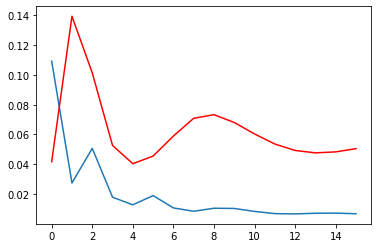

In [158]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"], color="red")

In [159]:
X_test.shape

(1, 336, 122)

In [160]:
result = model_1.predict(X_test)

In [161]:
result.shape

(1, 336, 1)

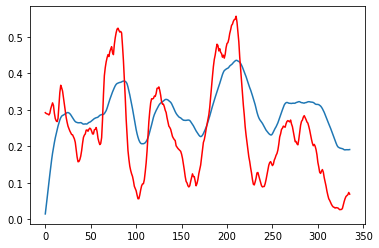

In [162]:
plt.plot(result.flatten())
plt.plot(y_test, color="red")

## Model_2 LStM, Many-to-Many with Encoder Decoder architecture

In [147]:
#imports imported above
#from keras.layers import RepeatVector
#from keras.layers import TimeDistributed

model_2 = Sequential()

# encoder layer
model_2.add(LSTM(100, activation='relu', input_shape=(timesteps,2)))

# repeat vector
model_2.add(RepeatVector(timesteps))

# decoder layer
model_2.add(LSTM(100, activation='relu', return_sequences=True))

model_2.add(TimeDistributed(Dense(1)))
model_2.compile(optimizer='adam', loss='mse', metrics=['mae', "mse"])

print(model_2.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 100)               41200     
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 4300, 100)         0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 4300, 100)         80400     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 4300, 1)           101       
Total params: 121,701
Trainable params: 121,701
Non-trainable params: 0
_________________________________________________________________
None


In [116]:
es2 = [EarlyStopping(monitor="val_loss", mode='min', patience = 12, restore_best_weights=True)] 

history_2 = model_2.fit(
    X_train, y_train,validation_data=(X_test, y_test), shuffle = False,  callbacks = es2, epochs=50, verbose=2)


NameError: ignored

In [117]:
testX.shape

(1, 336, 122)

In [118]:
plt.plot(history_2.history["loss"])
plt.plot(history_2.history["val_loss"], color="red")

NameError: ignored

In [119]:
result = model_2.predict(X_test)

NameError: ignored

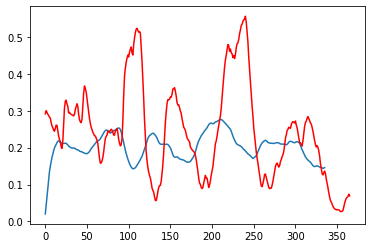

In [120]:
plt.plot(result.flatten())
plt.plot(y_test, color="red")

## Testing the MAPE score

In [50]:
def mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sum(np.abs(y_true-y_pred))/(len(y_true))

def mse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean((y_true-y_pred)**2)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [163]:
res = pd.DataFrame(result.flatten())
res[0];

In [164]:
mean_absolute_percentage_error(y_test[0], res[0])

16.935817897319794

Ideas to improve the model:
Does the split into 64 sequences make sense? Try 32?
try out different stride size in sequencing, maybe even tumbling 
window and no overlapping window

Multiple Layers:


### Unscaling and Comparing